<a href="https://colab.research.google.com/github/felipeabe/artificial-neural-network/blob/projetoComCSV/trabalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#uploading files
from google.colab import files
uploaded = files.upload()

#importing libs
import pandas as pd

Saving houses.csv to houses.csv


In [4]:

# importing multiclass dataset
dfm = pd.read_csv('obesity.csv')

#changing columns names
# Defining a dictionary with old column names as keys and new column names as values
column_mapping = {
    'family_history_with_overweight': 'family_overweight',
    'FAVC': 'caloric_food',
    'FCVC': 'eat_vegetables',
    'NCP': 'meals_day',
    'SMOKE': 'smoke',
    'CH2O': 'water_day',
    'SCC': 'track_calories',
    'FAF': 'physical_activity_week',
    'CALC': 'alcohol',
    'MTRANS': 'transportation_method',
    'NObeyesdad': 'obesity_level'
}

# Renaming the columns using the dictionary
dfm = dfm.rename(columns=column_mapping)


#Removing unnecessary columns
dfm = dfm.drop(columns=['CAEC', 'TUE'])

#encoding values (binary)
binary_mappings = {
    "Gender": {"Female": 0, "Male": 1},
    "family_overweight": {"yes": 1, "no": 0},
    "caloric_food": {"yes": 1, "no": 0},
    "smoke": {"yes": 1, "no": 0},
    "track_calories": {"yes": 1, "no": 0}
}

for col, mapping in binary_mappings.items():
    dfm[col] = dfm[col].map(mapping)

#encoding alcohol usage
encoding_map = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
dfm['alcohol'] = dfm['alcohol'].map(encoding_map)


#encoding transportation_method
custom_mapping = {
    "Walking": 0,
    "Bike": 0,
    "Motorbike": 1,
    "Automobile": 1,
    "Public_Transportation": 1
}
dfm['transportation_method'] = dfm['transportation_method'].map(custom_mapping)

#encoding output column (obesity_level)
obesity_mapping = {
    "Insufficient_Weight": 0,
    "Normal_Weight": 1,
    "Overweight_Level_I": 2,
    "Overweight_Level_II": 3,
    "Obesity_Type_I": 4,
    "Obesity_Type_II": 5,
    "Obesity_Type_III": 6
}
dfm['obesity_level'] = dfm ['obesity_level'].map(obesity_mapping)

#normalizing data
columns_to_normalize = ["Height", "Weight", "Age"]
dfm[columns_to_normalize] = dfm[columns_to_normalize].apply(
    lambda x: ((x - x.min()) / (x.max() - x.min())).round(3)
)

#spliting the dataframe
#training 80% of dataset
#testing 20% of dataset
split_point = int(0.8 * len(dfm))
train_multiclass = dfm[:split_point]
test_multiclass = dfm[split_point:]


dfm.head(10)

,Gender,Age,Height,Weight,family_overweight,caloric_food,eat_vegetables,meals_day,smoke,water_day,track_calories,physical_activity_week,alcohol,transportation_method,obesity_level
0,0,0.149,0.321,0.187,1,0,2.0,3.0,0,2.0,0,0.0,0,1,1
1,0,0.149,0.132,0.127,1,0,3.0,3.0,1,3.0,1,3.0,1,1,1
2,1,0.191,0.660,0.284,1,0,2.0,3.0,0,2.0,0,2.0,2,1,1
3,1,0.277,0.660,0.358,0,0,3.0,3.0,0,2.0,0,2.0,2,0,2
4,1,0.170,0.623,0.379,0,0,2.0,1.0,0,2.0,0,0.0,1,1,3
5,1,0.319,0.321,0.104,0,1,2.0,3.0,0,2.0,0,0.0,1,1,1
6,0,0.191,0.094,0.119,1,1,3.0,3.0,0,2.0,0,1.0,1,1,1
7,1,0.170,0.358,0.104,0,0,2.0,3.0,0,2.0,0,3.0,1,1,1
8,1,0.213,0.623,0.187,1,1,3.0,3.0,0,2.0,0,1.0,2,1,1
9,1,0.170,0.509,0.216,1,1,2.0,3.0,0,2.0,0,1.0,0,1,1


Treinando modelo com Binary Cross-Entropy...
Treinamento iniciado.
Funções de ativação usadas por camada: ['relu', 'tanh', 'sigmoid']
Função de perda: binary_cross_entropy
Epoch 0/100, Loss: 0.6931
Epoch 10/100, Loss: 0.6821
Epoch 20/100, Loss: 0.6736
Epoch 30/100, Loss: 0.6669
Epoch 40/100, Loss: 0.6617
Epoch 50/100, Loss: 0.6576
Epoch 60/100, Loss: 0.6545
Epoch 70/100, Loss: 0.6520
Epoch 80/100, Loss: 0.6500
Epoch 90/100, Loss: 0.6485
Epoch 100/100, Loss: 0.6473
Treinamento concluído.
Acurácia final: 65.74%

Treinando modelo com Mean Squared Error...
Treinamento iniciado.
Funções de ativação usadas por camada: ['relu', 'tanh', 'sigmoid']
Função de perda: mse
Epoch 0/100, Loss: 0.2500
Epoch 10/100, Loss: 0.2445
Epoch 20/100, Loss: 0.2402
Epoch 30/100, Loss: 0.2369
Epoch 40/100, Loss: 0.2343
Epoch 50/100, Loss: 0.2323
Epoch 60/100, Loss: 0.2308
Epoch 70/100, Loss: 0.2296
Epoch 80/100, Loss: 0.2287
Epoch 90/100, Loss: 0.2279
Epoch 100/100, Loss: 0.2274
Treinamento concluído.
Acurácia fi

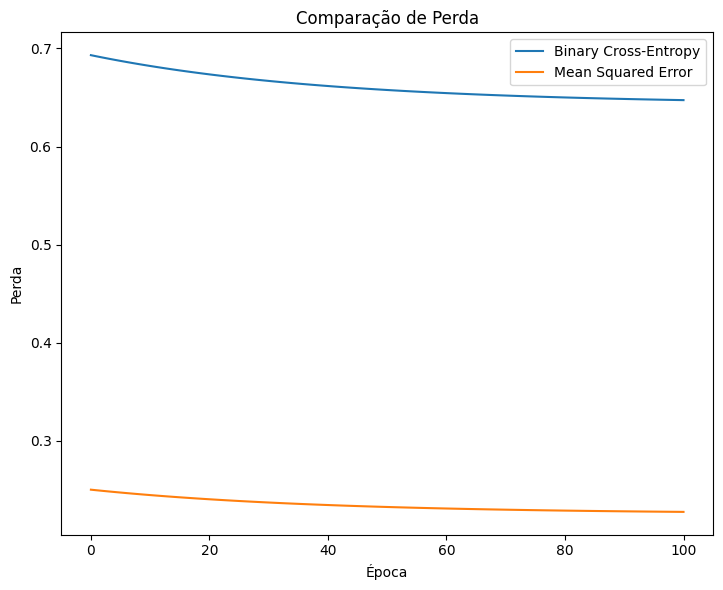

In [5]:
#import binary dataset
dfb = pd.read_csv('alzheimer.csv')
#outcome:
# 1- alzheimer
# 0- no alzheimer

#selecting useful columns
selected_columns = ['Age', 'Gender','Smoking', 'EducationLevel', 'BMI' ,'SleepQuality', 'CholesterolLDL', 'FamilyHistoryAlzheimers','PhysicalActivity', 'Diagnosis']
dfb = dfb[selected_columns]

#normalizing data
columns_to_normalize = ["BMI", "SleepQuality", "Age", "CholesterolLDL", "FamilyHistoryAlzheimers", "PhysicalActivity"]
dfb[columns_to_normalize] = dfb[columns_to_normalize].apply(
    lambda x: ((x - x.min()) / (x.max() - x.min())).round(3)
)

#spliting the dataframe
#training 80% of dataset
#testing 20% of dataset
split_point2 = int(0.8 * len(dfb))
train_binary = dfb[:split_point2]
test_binary = dfb[split_point2:]


import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Funções de ativação e derivadas
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

# Função de perda (Binary Cross-Entropy)
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-8
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Função de perda para MSE (erro quadrático médio)
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def plot_training_comparison(history_bce, history_mse):
    epochs = range(len(history_bce['loss']))

    # Gráfico de perda
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_bce['loss'], label='Binary Cross-Entropy')
    plt.plot(epochs, history_mse['loss'], label='Mean Squared Error')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.title('Comparação de Perda')
    plt.legend()


    plt.tight_layout()
    plt.show()

acuracia_final=0
class NeuralNetwork:
    def __init__(self, layers, activations, loss_function, learning_rate=0.01):
        self.layers = layers
        self.activations = activations
        self.learning_rate = learning_rate
        self.loss_functions = {
            'binary_cross_entropy': binary_cross_entropy,
            'mse': mse
        }
        if loss_function not in self.loss_functions:
            raise ValueError(f"Função de perda '{loss_function}' não suportada.")
        self.loss_function = self.loss_functions[loss_function]
        self.activation_functions = {
            'sigmoid': (sigmoid, sigmoid_derivative),
            'relu': (relu, relu_derivative),
            'tanh': (tanh, tanh_derivative)
        }
        self.weights = [np.random.randn(layers[i], layers[i - 1]) * 0.01 for i in range(1, len(layers))]
        self.biases = [np.zeros((layers[i], 1)) for i in range(1, len(layers))]
        self.history = {'loss': [], 'accuracy': []}  # Para registrar as métricas por época

    def forward(self, X):
        self.a = [X.T]  # Ativações (saídas) por camada
        self.z = []     # Soma ponderada (z = W.a + b)

        for i in range(len(self.weights)):
            z = np.dot(self.weights[i], self.a[-1]) + self.biases[i]
            self.z.append(z)
            activation_function = self.activation_functions[self.activations[i]][0]
            self.a.append(activation_function(z))

        return self.a[-1].T  # Saída final da rede

    def backward(self, X, y):
        m = X.shape[0]
        y = y.reshape(-1, 1).T
        d_weights = [np.zeros_like(w) for w in self.weights]
        d_biases = [np.zeros_like(b) for b in self.biases]

        # Cálculo do erro na saída
        dz = self.a[-1] - y  # Erro na saída
        for i in reversed(range(len(self.weights))):
            dw = np.dot(dz, self.a[i].T) / m
            db = np.sum(dz, axis=1, keepdims=True) / m
            d_weights[i] = dw
            d_biases[i] = db

            if i > 0:  # Propagação do erro para trás
                activation_derivative = self.activation_functions[self.activations[i - 1]][1]
                dz = np.dot(self.weights[i].T, dz) * activation_derivative(self.z[i-1])

        # Atualização dos pesos e bias
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * d_weights[i]
            self.biases[i] -= self.learning_rate * d_biases[i]

    def train(self, X, y, epochs=100):
        print("Treinamento iniciado.")
        print(f"Funções de ativação usadas por camada: {self.activations}")
        print(f"Função de perda: {self.loss_function.__name__}")

        for epoch in range(epochs + 1):  # Inclui a época 0
            y_pred = self.forward(X)
            loss = self.loss_function(y, y_pred)
            self.history['loss'].append(loss)

            # Calcular acurácia (se aplicável)
            accuracy = np.mean((y_pred > 0.5).astype(int) == y.reshape(-1, 1))
            acuracia_final=accuracy

            self.backward(X, y)

            # Exibir progresso a cada 10 épocas
            if epoch % 10 == 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")

        print("Treinamento concluído.")
        print(f'Acurácia final: {(accuracy*100).round(2)}%')


    def predict(self, X):
        y_pred = self.forward(X)
        return (y_pred > 0.5).astype(int)

# Dados de treino e teste
train_data = train_binary
test_data = test_binary

X_train = train_data.drop(columns=['Diagnosis']).values
y_train = train_data['Diagnosis'].values
X_test = test_data.drop(columns=['Diagnosis']).values
y_test = test_data['Diagnosis'].values



# Treinar o primeiro modelo (Binary Cross-Entropy)
print("Treinando modelo com Binary Cross-Entropy...")
nn_bce = NeuralNetwork(
    layers=[X_train.shape[1], 10, 5, 1],
    activations=['relu', 'tanh', 'sigmoid'],
    loss_function='binary_cross_entropy',
    learning_rate=0.05
)

nn_bce.train(X_train, y_train, epochs=100)

# Treinar o segundo modelo (Mean Squared Error)
print("\nTreinando modelo com Mean Squared Error...")
nn_mse = NeuralNetwork(
    layers=[X_train.shape[1], 10, 5, 1],
    activations=['relu', 'tanh', 'sigmoid'],
    loss_function='mse',
    learning_rate=0.05
)
nn_mse.train(X_train, y_train, epochs=100)

# Avaliar o modelo com BCE
y_pred_bce = nn_bce.predict(X_test)
accuracy_bce = accuracy_score(y_test, y_pred_bce)



# Avaliar o modelo com MSE
y_pred_mse = nn_mse.predict(X_test)
accuracy_mse = accuracy_score(y_test, y_pred_mse)
print(f"Accuracy do modelo com Mean Squared Error: {accuracy_mse:.2%}")

# Plotar os gráficos de comparação
plot_training_comparison(nn_bce.history, nn_mse.history)

In [6]:
#import regression dataset
dfr = pd.read_csv('houses.csv')

#removing columns
dfr = dfr.drop(columns=['renovated', 'quartile_zone'])

#encoding true/false
dfr = dfr.replace({True: 1, False: 0})

#Extracting the year from the data
# Convert 'date' column to datetime format
dfr['date'] = pd.to_datetime(dfr['date'])
# Extract the year and replace the original 'date' column
dfr['date'] = dfr['date'].dt.year

#normalizing data
columns_to_normalize = ["price", "living_in_m2"]
dfr[columns_to_normalize] = dfr[columns_to_normalize].apply(
    lambda x: ((x - x.min()) / (x.max() - x.min())).round(3)
)


#spliting the dataframe
#training 80% of dataset
#testing 20% of dataset
split_point3 = int(0.8 * len(dfr))
train_regression = dfr[:split_point3]
test_regression = dfr[split_point3:]

train_regression.head(10)

<ipython-input-6-1c407e60d625>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfr = dfr.replace({True: 1, False: 0})


,date,price,bedrooms,grade,has_basement,living_in_m2,nice_view,perfect_condition,real_bathrooms,has_lavatory,single_floor,month
0,2014,0.215,2,2,1,0.261,0,0,2,1,0,5
1,2014,0.213,2,2,0,0.166,0,0,1,1,0,11
2,2014,0.223,2,2,0,0.201,1,0,1,0,1,12
3,2015,0.171,2,3,0,0.299,0,0,2,1,1,2
4,2015,0.576,3,2,1,0.856,0,0,3,0,0,1
5,2015,0.339,1,2,1,0.103,1,0,1,0,1,3
6,2014,0.149,2,2,1,0.253,0,0,1,1,1,6
7,2014,0.143,1,1,0,0.264,0,0,1,0,1,10
8,2014,0.116,2,2,0,0.166,0,0,1,1,1,7
9,2014,0.432,2,3,0,0.204,0,0,2,1,0,9


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Funções de ativação e derivadas
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

# Funções de perda
def cross_entropy_loss(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))

def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Implementação da Rede Neural para Classificação Binária
class NeuralNetworkBinary:
    def __init__(self, input_size, hidden_size, activation="relu", loss="cross_entropy"):
        # Inicializa os pesos e biases
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.01
        self.bias_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, 1) * 0.01
        self.bias_output = np.zeros((1, 1))

        # Configurar função de ativação
        self.activation = activation
        self.loss = loss

        if activation == "relu":
            self.activation_func = relu
            self.activation_derivative = relu_derivative
        elif activation == "sigmoid":
            self.activation_func = sigmoid
            self.activation_derivative = sigmoid_derivative
        elif activation == "tanh":
            self.activation_func = tanh
            self.activation_derivative = tanh_derivative
        else:
            raise ValueError("Ativação inválida! Escolha entre 'relu', 'sigmoid' ou 'tanh'.")

        # Configurar função de perda
        if loss == "cross_entropy":
            self.loss_func = cross_entropy_loss
        elif loss == "mse":
            self.loss_func = mse_loss
        else:
            raise ValueError("Função de perda inválida! Escolha entre 'cross_entropy' ou 'mse'.")

    def forward(self, X):
        # Propagação para frente
        self.z1 = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.a1 = self.activation_func(self.z1)
        self.z2 = np.dot(self.a1, self.weights_hidden_output) + self.bias_output
        self.a2 = sigmoid(self.z2)  # A saída final é sempre sigmoid (probabilidade)
        return self.a2

    def backward(self, X, y, learning_rate):
        # Propagação para trás (retropropagação)
        m = X.shape[0]
        output_error = self.a2 - y  # Erro da saída (derivada da cross-entropy com sigmoide)

        # Gradientes para a camada de saída
        dw2 = np.dot(self.a1.T, output_error) / m
        db2 = np.sum(output_error, axis=0, keepdims=True) / m

        # Gradientes para a camada oculta
        hidden_error = np.dot(output_error, self.weights_hidden_output.T) * self.activation_derivative(self.z1)
        dw1 = np.dot(X.T, hidden_error) / m
        db1 = np.sum(hidden_error, axis=0, keepdims=True) / m

        # Atualizar pesos e biases
        self.weights_hidden_output -= learning_rate * dw2
        self.bias_output -= learning_rate * db2
        self.weights_input_hidden -= learning_rate * dw1
        self.bias_hidden -= learning_rate * db1

    def compute_loss(self, y_true, y_pred):
        return self.loss_func(y_true, y_pred)

# Carregar e processar o conjunto de dados
alzheimer_path = "alzheimer.csv"
alzheimer_data = pd.read_csv(alzheimer_path)

# Remover colunas irrelevantes
alzheimer_cleaned = alzheimer_data.drop(columns=["PatientID", "DoctorInCharge"])

# Separar variáveis categóricas e numéricas
categorical_columns = ["Gender", "Ethnicity", "EducationLevel"]
numerical_columns = [col for col in alzheimer_cleaned.columns if col not in categorical_columns + ["Diagnosis"]]

# Codificar variáveis categóricas
encoder = OneHotEncoder(drop="first", sparse_output=False)  # Evitar multicolinearidade
categorical_encoded = encoder.fit_transform(alzheimer_cleaned[categorical_columns])
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Normalizar variáveis numéricas
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(alzheimer_cleaned[numerical_columns])
numerical_scaled_df = pd.DataFrame(numerical_scaled, columns=numerical_columns)

# Combinar dados processados e alvo
processed_data = pd.concat([numerical_scaled_df, categorical_encoded_df], axis=1)
processed_data["Diagnosis"] = alzheimer_cleaned["Diagnosis"]

# Dividir em conjuntos de treino e teste
X = processed_data.drop(columns=["Diagnosis"])
y = processed_data["Diagnosis"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converter para numpy arrays
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy().reshape(-1, 1)
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy().reshape(-1, 1)

# Configurações da rede neural
input_size = X_train_np.shape[1]  # Número de features
hidden_size = 10  # Número de neurônios na camada oculta
learning_rate = 0.01
epochs = 1000

# Instanciar a rede neural mse
nn_binary = NeuralNetworkBinary(input_size=input_size, hidden_size=hidden_size, activation="tanh", loss="mse")

# Treinamento
losses = []
for epoch in range(epochs):
    # Forward pass
    y_pred = nn_binary.forward(X_train_np)
    # Calcular perda
    loss = nn_binary.compute_loss(y_train_np, y_pred)
    losses.append(loss)
    # Backward pass
    nn_binary.backward(X_train_np, y_train_np, learning_rate)

    # Exibir o progresso
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")

# Avaliação no conjunto de teste
y_test_pred = nn_binary.forward(X_test_np)
test_accuracy = np.mean((y_test_pred > 0.5) == y_test_np)
print(f"Acurácia no conjunto de teste utilizando {nn_binary.loss}: {test_accuracy * 100:.2f}% \n")

# Instanciar a rede neural cross
nn_binary = NeuralNetworkBinary(input_size=input_size, hidden_size=hidden_size, activation="tanh", loss="cross_entropy")

# Treinamento
losses = []
for epoch in range(epochs):
    # Forward pass
    y_pred = nn_binary.forward(X_train_np)
    # Calcular perda
    loss = nn_binary.compute_loss(y_train_np, y_pred)
    losses.append(loss)
    # Backward pass
    nn_binary.backward(X_train_np, y_train_np, learning_rate)

    # Exibir o progresso
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")

# Avaliação no conjunto de teste
y_test_pred = nn_binary.forward(X_test_np)
test_accuracy = np.mean((y_test_pred > 0.5) == y_test_np)
print(f"Acurácia no conjunto de teste utilizando {nn_binary.loss}: {test_accuracy * 100:.2f}% \n")


Epoch 0/1000, Loss: 0.2500
Epoch 100/1000, Loss: 0.2414
Epoch 200/1000, Loss: 0.2361
Epoch 300/1000, Loss: 0.2327
Epoch 400/1000, Loss: 0.2303
Epoch 500/1000, Loss: 0.2282
Epoch 600/1000, Loss: 0.2258
Epoch 700/1000, Loss: 0.2222
Epoch 800/1000, Loss: 0.2166
Epoch 900/1000, Loss: 0.2077
Acurácia no conjunto de teste utilizando mse: 66.28% 

Epoch 0/1000, Loss: 0.6931
Epoch 100/1000, Loss: 0.6759
Epoch 200/1000, Loss: 0.6653
Epoch 300/1000, Loss: 0.6585
Epoch 400/1000, Loss: 0.6537
Epoch 500/1000, Loss: 0.6495
Epoch 600/1000, Loss: 0.6448
Epoch 700/1000, Loss: 0.6379
Epoch 800/1000, Loss: 0.6271
Epoch 900/1000, Loss: 0.6099
Acurácia no conjunto de teste utilizando cross_entropy: 64.88% 



In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalizar o alvo (price) para valores entre 0 e 1
from sklearn.preprocessing import MinMaxScaler

# Funções de ativação e derivadas
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def linear(x):
    return x  # Ativação linear para regressão

def linear_derivative(x):
    return np.ones_like(x)

# Funções de perda
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae_loss(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

price_scaler = MinMaxScaler()
y_train_scaled = price_scaler.fit_transform(y_train_np)
y_test_scaled = price_scaler.transform(y_test_np)

# Modificar a classe NeuralNetworkRegression para incluir ajustes na inicialização dos pesos
class NeuralNetworkRegressionV2:
    def __init__(self, input_size, hidden_size, activation="relu", loss="mse"):
        self.loss_type = loss  # Armazena o tipo de perda escolhido
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.001
        self.bias_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, 1) * 0.001
        self.bias_output = np.zeros((1, 1))

        # Configurar função de ativação
        if activation == "relu":
            self.activation_func = relu
            self.activation_derivative = relu_derivative
        else:
            raise ValueError("Ativação inválida! Apenas 'relu' é suportado para regressão.")

        # Configurar função de perda
        if loss == "mse":
            self.loss_func = mse_loss
        elif loss == "mae":
            self.loss_func = mae_loss
        else:
            raise ValueError("Função de perda inválida! Escolha entre 'mse' ou 'mae'.")

    def forward(self, X):
        # Propagação para frente
        self.z1 = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.a1 = self.activation_func(self.z1)
        self.z2 = np.dot(self.a1, self.weights_hidden_output) + self.bias_output
        self.a2 = linear(self.z2)  # Ativação linear na saída
        return self.a2

    def backward(self, X, y, learning_rate):
        # Propagação para trás (retropropagação)
        m = X.shape[0]
        output_error = self.a2 - y  # Erro da saída

        # Gradientes para a camada de saída
        dw2 = np.dot(self.a1.T, output_error) / m
        db2 = np.sum(output_error, axis=0, keepdims=True) / m

        # Gradientes para a camada oculta
        hidden_error = np.dot(output_error, self.weights_hidden_output.T) * self.activation_derivative(self.z1)
        dw1 = np.dot(X.T, hidden_error) / m
        db1 = np.sum(hidden_error, axis=0, keepdims=True) / m

        # Atualizar pesos e biases
        self.weights_hidden_output -= learning_rate * dw2
        self.bias_output -= learning_rate * db2
        self.weights_input_hidden -= learning_rate * dw1
        self.bias_hidden -= learning_rate * db1

    def compute_loss(self, y_true, y_pred):
        return self.loss_func(y_true, y_pred)

# Instanciar a rede neural corrigida
nn_regression_v2 = NeuralNetworkRegressionV2(
    input_size=input_size, hidden_size=hidden_size, activation="relu", loss="mse"
)

# Treinamento
losses_v2 = []
for epoch in range(epochs):
    # Forward pass
    y_pred_scaled = nn_regression_v2.forward(X_train_np)
    # Calcular perda
    loss_v2 = nn_regression_v2.compute_loss(y_train_scaled, y_pred_scaled)
    losses_v2.append(loss_v2)
    # Backward pass
    nn_regression_v2.backward(X_train_np, y_train_scaled, learning_rate)

    # Exibir o progresso
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss_v2:.6f}")
        if np.isnan(loss_v2):  # Parar se a perda se tornar inválida
            print("Treinamento interrompido devido a perda inválida (NaN).")
            break

# Perda no conjunto de teste (normalizada)
y_test_pred_scaled = nn_regression_v2.forward(X_test_np)
test_loss_scaled = nn_regression_v2.compute_loss(y_test_scaled, y_test_pred_scaled)

# Reverter a escala para obter as previsões originais
y_test_pred = price_scaler.inverse_transform(y_test_pred_scaled)

# Perda no conjunto de teste (escala original)
if nn_regression_v2.loss_type == "mse":
    test_loss_original = mse_loss(y_test_np, y_test_pred)
elif nn_regression_v2.loss_type == "mae":
    test_loss_original = mae_loss(y_test_np, y_test_pred)

# Imprimir as perdas
print(f"Loss no conjunto de teste (normalizada): {test_loss_scaled:.6f}")
print(f"Loss no conjunto de teste ({nn_regression_v2.loss_type.upper()}): {test_loss_original:.4f} \n")

# Instanciar a rede neural corrigida
nn_regression_v2 = NeuralNetworkRegressionV2(
    input_size=input_size, hidden_size=hidden_size, activation="relu", loss="mae"
)

# Treinamento
losses_v2 = []
for epoch in range(epochs):
    # Forward pass
    y_pred_scaled = nn_regression_v2.forward(X_train_np)
    # Calcular perda
    loss_v2 = nn_regression_v2.compute_loss(y_train_scaled, y_pred_scaled)
    losses_v2.append(loss_v2)
    # Backward pass
    nn_regression_v2.backward(X_train_np, y_train_scaled, learning_rate)

    # Exibir o progresso
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss_v2:.6f}")
        if np.isnan(loss_v2):  # Parar se a perda se tornar inválida
            print("Treinamento interrompido devido a perda inválida (NaN).")
            break

# Perda no conjunto de teste (normalizada)
y_test_pred_scaled = nn_regression_v2.forward(X_test_np)
test_loss_scaled = nn_regression_v2.compute_loss(y_test_scaled, y_test_pred_scaled)

# Reverter a escala para obter as previsões originais
y_test_pred = price_scaler.inverse_transform(y_test_pred_scaled)

# Perda no conjunto de teste (escala original)
if nn_regression_v2.loss_type == "mse":
    test_loss_original = mse_loss(y_test_np, y_test_pred)
elif nn_regression_v2.loss_type == "mae":
    test_loss_original = mae_loss(y_test_np, y_test_pred)

# Imprimir as perdas
print(f"Loss no conjunto de teste (normalizada): {test_loss_scaled:.6f}")
print(f"Loss no conjunto de teste ({nn_regression_v2.loss_type.upper()}): {test_loss_original:.4f} \n")

Epoch 0/1000, Loss: 0.172149
Epoch 100/1000, Loss: 0.055596
Epoch 200/1000, Loss: 0.039981
Epoch 300/1000, Loss: 0.037888
Epoch 400/1000, Loss: 0.037607
Epoch 500/1000, Loss: 0.037568
Epoch 600/1000, Loss: 0.037562
Epoch 700/1000, Loss: 0.037559
Epoch 800/1000, Loss: 0.037557
Epoch 900/1000, Loss: 0.037554
Loss no conjunto de teste (normalizada): 0.036027
Loss no conjunto de teste (MSE): 41556247415.7702 

Epoch 0/1000, Loss: 0.366848
Epoch 100/1000, Loss: 0.173553
Epoch 200/1000, Loss: 0.154050
Epoch 300/1000, Loss: 0.154531
Epoch 400/1000, Loss: 0.155699
Epoch 500/1000, Loss: 0.156233
Epoch 600/1000, Loss: 0.156439
Epoch 700/1000, Loss: 0.156512
Epoch 800/1000, Loss: 0.156536
Epoch 900/1000, Loss: 0.156539
Loss no conjunto de teste (normalizada): 0.151573
Loss no conjunto de teste (MAE): 162788.9675 



Epoch 1/100
341/341 [==============================] - 6s 12ms/step - loss: 231.7535 - val_loss: 1.0664
Epoch 2/100
341/341 [==============================] - 2s 5ms/step - loss: 0.9870 - val_loss: 0.8013
Epoch 3/100
341/341 [==============================] - 2s 6ms/step - loss: 0.8608 - val_loss: 0.7100
Epoch 4/100
341/341 [==============================] - 1s 2ms/step - loss: 0.7313 - val_loss: 1.9457
Epoch 5/100
341/341 [==============================] - 1s 2ms/step - loss: 0.6701 - val_loss: 0.5104
Epoch 6/100
341/341 [==============================] - 1s 2ms/step - loss: 0.5657 - val_loss: 0.4852
Epoch 7/100
341/341 [==============================] - 1s 2ms/step - loss: 0.5909 - val_loss: 0.4184
Epoch 8/100
341/341 [==============================] - 1s 2ms/step - loss: 0.5869 - val_loss: 1.6140
Epoch 9/100
341/341 [==============================] - 1s 2ms/step - loss: 0.4885 - val_loss: 0.7760
Epoch 10/100
341/341 [==============================] - 1s 2ms/step - loss: 0.4945 - val

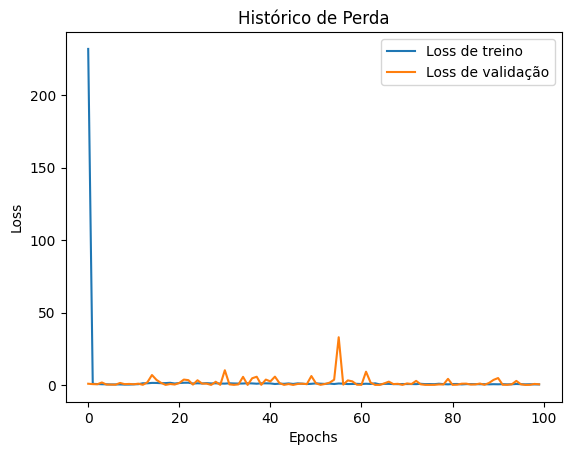

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tf_keras import Sequential
from tf_keras.layers import Dense

# Carregar os dados
houses_data = pd.read_csv('houses.csv')

# Normalizar as colunas numéricas
numerical_columns = ['price', 'bedrooms', 'grade', 'living_in_m2', 'real_bathrooms', 'month']
scaler = StandardScaler()
houses_data[numerical_columns] = scaler.fit_transform(houses_data[numerical_columns])

# Converter as variáveis categóricas para valores binários
categorical_columns = ['has_basement', 'renovated', 'nice_view', 'perfect_condition', 'has_lavatory', 'single_floor']
houses_data[categorical_columns] = houses_data[categorical_columns].astype(int)

# Converter a coluna de data para o formato numérico (ano e mês)
houses_data['date'] = pd.to_datetime(houses_data['date'])
houses_data['year'] = houses_data['date'].dt.year
houses_data['month'] = houses_data['date'].dt.month
houses_data.drop('date', axis=1, inplace=True)  # Remover a coluna 'date' original

# Separar variáveis independentes (X) e dependentes (y)
X = houses_data.drop('price', axis=1).values
y = houses_data['price'].values

# Dividir os dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construir o modelo com Keras
model = Sequential()

# Adicionar camada densa de entrada (input) e camada oculta
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Primeira camada oculta com ReLU
model.add(Dense(32, activation='relu'))  # Segunda camada oculta com ReLU

# Camada de saída (para regressão, sem função de ativação)
model.add(Dense(1))

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Avaliar o modelo
y_pred = model.predict(X_test)

# Calcular as métricas de erro
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)

print(f"Loss no conjunto de teste MSE: {mse_test:.4f}")
print(f"Loss no conjunto de teste MAE: {mae_test:.4f}")

# Visualizar o histórico de perda durante o treinamento
plt.plot(history.history['loss'], label='Loss de treino')
plt.plot(history.history['val_loss'], label='Loss de validação')
plt.title('Histórico de Perda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
